In [2]:
# Install required packages
!pip install -q transformers datasets nltk spacy pandas numpy torch

import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM
import nltk
import spacy
from tqdm.notebook import tqdm

# Download ALL required NLTK data explicitly
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')  # Open Multilingual Wordnet
!python -m spacy download en_core_web_sm

# Wait a moment to ensure downloads complete
import time
time.sleep(5)

class SimpleWikiDataset:
    def __init__(self, num_examples=1000):  # Reduced default size for testing
        """
        Initialize and load SimpleWiki dataset
        num_examples: Number of examples to load
        """
        self.num_examples = num_examples
        self.train_data = None
        self.val_data = None
        self.test_data = None

    def load_data(self):
        """Load and prepare SimpleWiki dataset"""
        print("Loading SimpleWiki dataset...")
        try:
            # Load the Wikipedia dataset
            dataset = load_dataset("wikipedia", "20220301.simple", split="train")

            # Extract text and prepare examples
            examples = []
            for article in tqdm(dataset.select(range(self.num_examples))):
                if article['text'] and len(article['text'].split()) > 10:
                    examples.append({
                        'text': article['text'],
                        'title': article['title']
                    })

            # Convert to DataFrame
            df = pd.DataFrame(examples)

            # Split into sentences using nltk
            def safe_sent_tokenize(text):
                try:
                    return nltk.sent_tokenize(text)
                except Exception as e:
                    print(f"Error tokenizing text: {e}")
                    return [text]  # Return full text as single sentence if tokenization fails

            df['sentences'] = df['text'].apply(safe_sent_tokenize)

            # Explode DataFrame to get one row per sentence
            df_sentences = df.explode('sentences').reset_index(drop=True)
            df_sentences = df_sentences[df_sentences['sentences'].str.len() > 20]

            # Split into train, validation, and test sets
            train_size = int(0.8 * len(df_sentences))
            val_size = int(0.1 * len(df_sentences))

            self.train_data = df_sentences[:train_size]
            self.val_data = df_sentences[train_size:train_size+val_size]
            self.test_data = df_sentences[train_size+val_size:]

            print(f"Dataset split complete:")
            print(f"Train set: {len(self.train_data)} sentences")
            print(f"Validation set: {len(self.val_data)} sentences")
            print(f"Test set: {len(self.test_data)} sentences")

            return self.train_data, self.val_data, self.test_data

        except Exception as e:
            print(f"Error loading dataset: {e}")
            raise

class SimplificationPipeline:
    def __init__(self):
        print("Initializing SimplificationPipeline...")
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.model = AutoModelForMaskedLM.from_pretrained('bert-base-uncased')
        self.nlp = spacy.load('en_core_web_sm')
        print("Pipeline initialized successfully")

    def simplify_text(self, text):
        """Main simplification pipeline"""
        try:
            # Split into sentences
            sentences = nltk.sent_tokenize(text)

            simplified_sentences = []
            for sentence in sentences:
                # Process each sentence
                doc = self.nlp(sentence)

                # Simplify complex words
                simplified_words = []
                for token in doc:
                    if self.is_complex_word(token):
                        simpler_word = self.find_simpler_word(token.text, sentence)
                        simplified_words.append(simpler_word if simpler_word else token.text)
                    else:
                        simplified_words.append(token.text)

                simplified_sent = ' '.join(simplified_words)
                simplified_sentences.append(simplified_sent)

            return ' '.join(simplified_sentences)
        except Exception as e:
            print(f"Error in simplify_text: {e}")
            return text  # Return original text if simplification fails

    def is_complex_word(self, token):
        """Determine if a word is complex based on length and POS"""
        return (
            len(token.text) > 6 and
            token.pos_ in ['NOUN', 'VERB', 'ADJ'] and
            not token.is_stop and
            not token.is_punct and
            not token.like_num
        )

    def find_simpler_word(self, word, context):
        """Find a simpler alternative for a complex word"""
        try:
            # Mask the word in context
            masked_text = context.replace(word, self.tokenizer.mask_token)

            # Get model predictions
            inputs = self.tokenizer(masked_text, return_tensors='pt')
            with torch.no_grad():
                outputs = self.model(**inputs)

            # Get top 5 predictions
            mask_idx = torch.where(inputs['input_ids'][0] == self.tokenizer.mask_token_id)[0]
            if len(mask_idx) == 0:
                return None

            probs = outputs.logits[0, mask_idx].softmax(dim=-1)
            top_k = torch.topk(probs, 5, dim=-1)

            # Select the shortest word from top predictions
            candidates = [self.tokenizer.decode([token_id]) for token_id in top_k.indices[0]]
            candidates = [c for c in candidates if c.lower() != word.lower() and len(c) < len(word)]

            return candidates[0] if candidates else None
        except Exception as e:
            print(f"Error in find_simpler_word: {e}")
            return None

def evaluate_simplification(original, simplified):
    """Calculate basic evaluation metrics"""
    try:
        # Average word length
        orig_words = original.split()
        simp_words = simplified.split()

        if not orig_words or not simp_words:
            return None

        avg_orig_len = sum(len(w) for w in orig_words) / len(orig_words)
        avg_simp_len = sum(len(w) for w in simp_words) / len(simp_words)

        # Compression ratio
        compression = len(simp_words) / len(orig_words)

        return {
            'avg_original_word_length': round(avg_orig_len, 2),
            'avg_simplified_word_length': round(avg_simp_len, 2),
            'compression_ratio': round(compression, 2)
        }
    except Exception as e:
        print(f"Error in evaluate_simplification: {e}")
        return None

def main():
    try:
        print("Starting main execution...")

        # Initialize dataset and pipeline
        dataset = SimpleWikiDataset(num_examples=100)  # Start with small number for testing
        train_data, val_data, test_data = dataset.load_data()

        simplifier = SimplificationPipeline()

        # Process some examples from test set
        print("\nSimplification Examples:")
        for _, row in test_data.head(3).iterrows():
            original = row['sentences']
            print("\nProcessing sentence:", original[:100], "...")  # Print first 100 chars

            simplified = simplifier.simplify_text(original)
            metrics = evaluate_simplification(original, simplified)

            print("\nOriginal:", original)
            print("Simplified:", simplified)
            if metrics:
                print("Metrics:", metrics)

    except Exception as e:
        print(f"Error in main: {e}")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Starting main execution...
Loading SimpleWiki dataset...


  0%|          | 0/100 [00:00<?, ?it/s]

Error tokenizing text: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Error tokenizing text: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

Pipeline initialized successfully

Simplification Examples:

Processing sentence: A comet is a ball of mostly ice that moves around in outer space. Comets are often described as "dir ...
Error in simplify_text: 
**********************************************************************
  Resource punkt_tab not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt_tab')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt_tab/english/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


Original: A comet is a ball of mostly ice that moves around in outer space. Comets are often described as "dirty snowballs". They are very differen

In [4]:
import nltk

# Download all necessary NLTK data
nltk.download('all')  # This will download everything NLTK needs

# Alternative: download only what we need
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root

True

Loading SimpleWiki dataset...


  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset split complete:
Train set: 29915 sentences
Validation set: 3739 sentences
Test set: 3740 sentences
Initializing SimplificationPipeline...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Pipeline initialized successfully
Processing test samples...
Processed 34360 samples...
Processed 34370 samples...
Processed 34380 samples...
Processed 34390 samples...
Processed 34400 samples...

Example Simplifications:

Example 1:
Original: Some lived by the ocean and lived mostly on fish.
Simplified: Some lived by the ocean and lived mostly on fish .
Metrics: {'length_reduction': 0.0, 'orig_avg_word_len': 3.64, 'simp_avg_word_len': 3.64}

Example 2:
Original: Another group lived along the warmer rivers.
Simplified: Another group lived along the warmer rivers .
Metrics: {'length_reduction': 0.0, 'orig_avg_word_len': 4.75, 'simp_avg_word_len': 4.75}

Example 3:
Original: These people did a little farming, hunting, and fishing to live.
Simplified: These people did a little farming , hunting , and where to live .
Metrics: {'length_reduction': 0.0, 'orig_avg_word_len': 3.86, 'simp_avg_word_len': 3.71}

Generating analysis plots...


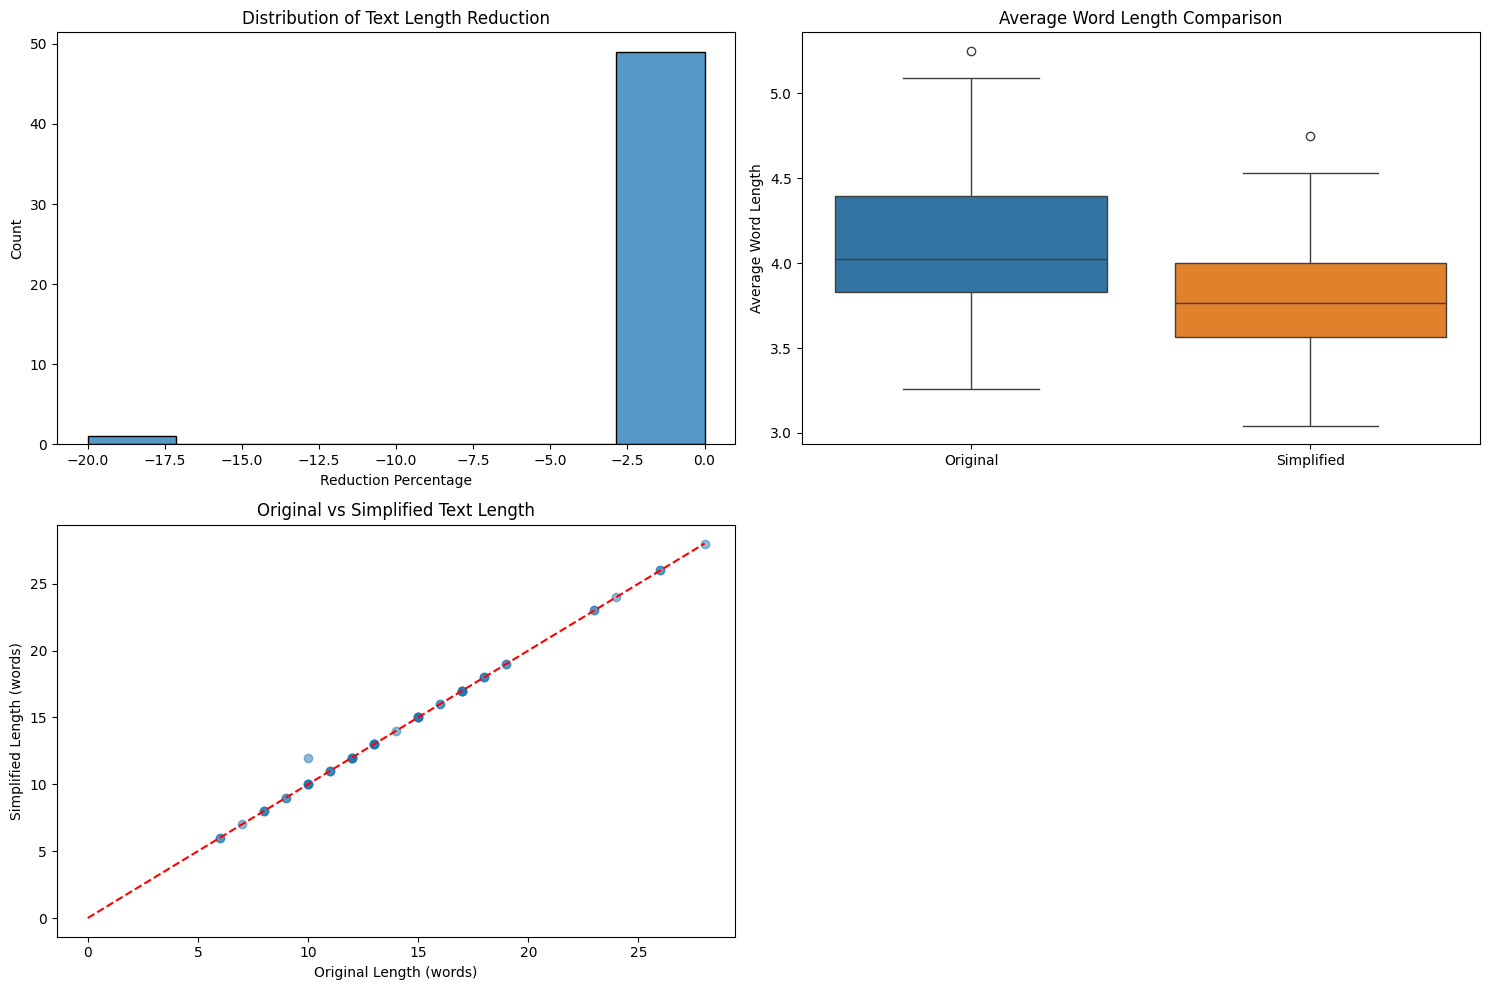

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from collections import defaultdict

class SimplificationAnalyzer:
    def __init__(self):
        self.results = defaultdict(list)

    def analyze_simplification(self, original, simplified):
        """Analyze differences between original and simplified text"""
        # Word length analysis
        orig_words = word_tokenize(original)
        simp_words = word_tokenize(simplified)

        self.results['original_lengths'].append(len(orig_words))
        self.results['simplified_lengths'].append(len(simp_words))
        self.results['length_reduction'].append((len(orig_words) - len(simp_words)) / len(orig_words) * 100)

        # Average word length
        orig_avg_word_len = sum(len(word) for word in orig_words) / len(orig_words)
        simp_avg_word_len = sum(len(word) for word in simp_words) / len(simp_words)

        self.results['orig_avg_word_len'].append(orig_avg_word_len)
        self.results['simp_avg_word_len'].append(simp_avg_word_len)

        return {
            'length_reduction': round((len(orig_words) - len(simp_words)) / len(orig_words) * 100, 2),
            'orig_avg_word_len': round(orig_avg_word_len, 2),
            'simp_avg_word_len': round(simp_avg_word_len, 2)
        }

    def plot_results(self):
        """Create visualizations of simplification results"""
        plt.figure(figsize=(15, 10))

        # Plot 1: Length reduction distribution
        plt.subplot(2, 2, 1)
        sns.histplot(self.results['length_reduction'])
        plt.title('Distribution of Text Length Reduction')
        plt.xlabel('Reduction Percentage')
        plt.ylabel('Count')

        # Plot 2: Word length comparison
        plt.subplot(2, 2, 2)
        data = {
            'Original': self.results['orig_avg_word_len'],
            'Simplified': self.results['simp_avg_word_len']
        }
        sns.boxplot(data=data)
        plt.title('Average Word Length Comparison')
        plt.ylabel('Average Word Length')

        # Plot 3: Text length comparison
        plt.subplot(2, 2, 3)
        plt.scatter(self.results['original_lengths'], self.results['simplified_lengths'], alpha=0.5)
        max_len = max(max(self.results['original_lengths']), max(self.results['simplified_lengths']))
        plt.plot([0, max_len], [0, max_len], 'r--')
        plt.title('Original vs Simplified Text Length')
        plt.xlabel('Original Length (words)')
        plt.ylabel('Simplified Length (words)')

        plt.tight_layout()
        plt.show()

def process_batch(dataset, simplifier, analyzer, num_samples=100):
    """Process a batch of examples and collect results"""
    results = []

    for idx, row in dataset.head(num_samples).iterrows():
        original = row['sentences']
        simplified = simplifier.simplify_text(original)

        analysis = analyzer.analyze_simplification(original, simplified)
        results.append({
            'original': original,
            'simplified': simplified,
            'metrics': analysis
        })

        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1} samples...")

    return results

def main():
    # Initialize components
    dataset = SimpleWikiDataset(num_examples=1000)
    train_data, val_data, test_data = dataset.load_data()
    simplifier = SimplificationPipeline()
    analyzer = SimplificationAnalyzer()

    print("Processing test samples...")
    results = process_batch(test_data, simplifier, analyzer, num_samples=50)

    # Print some example results
    print("\nExample Simplifications:")
    for i, result in enumerate(results[:3]):
        print(f"\nExample {i+1}:")
        print("Original:", result['original'])
        print("Simplified:", result['simplified'])
        print("Metrics:", result['metrics'])

    # Generate visualizations
    print("\nGenerating analysis plots...")
    analyzer.plot_results()

if __name__ == "__main__":
    main()

Initializing components...
Loading SimpleWiki dataset...


  0%|          | 0/200 [00:00<?, ?it/s]

Dataset split complete:
Train set: 6324 sentences
Validation set: 790 sentences
Test set: 792 sentences
Initializing SimplificationPipeline...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Pipeline initialized successfully

Processing test samples and collecting metrics...
Processed 7230 examples...
Processed 7240 examples...
Processed 7250 examples...
Processed 7260 examples...
Processed 7270 examples...

Summary Statistics:
Average length reduction: -0.60%
Average word length reduction: 0.29

Example Simplifications:

Example 1:
Original: These were very cruel wars.
Simplified: These were very cruel wars .
Length reduction: 0.00%

Example 2:
Original: In the year 1492, they took the last part of Spain that had belonged to the Moors.
Simplified: In the year 1492 , they took the last part of Spain that had fallen to the Moors .
Length reduction: 0.00%

Example 3:
Original: Boabdil, the last Moorish Leader of Granada, gave the city to King Ferdinand of Aragon on 2 January 1492, and Christians now ruled all of Spain.
Simplified: Boabdil , the last Moorish Leader of Granada , gave the city to King Ferdinand of Aragon on 2 January 1492 , and Christians now ruled all of Spain

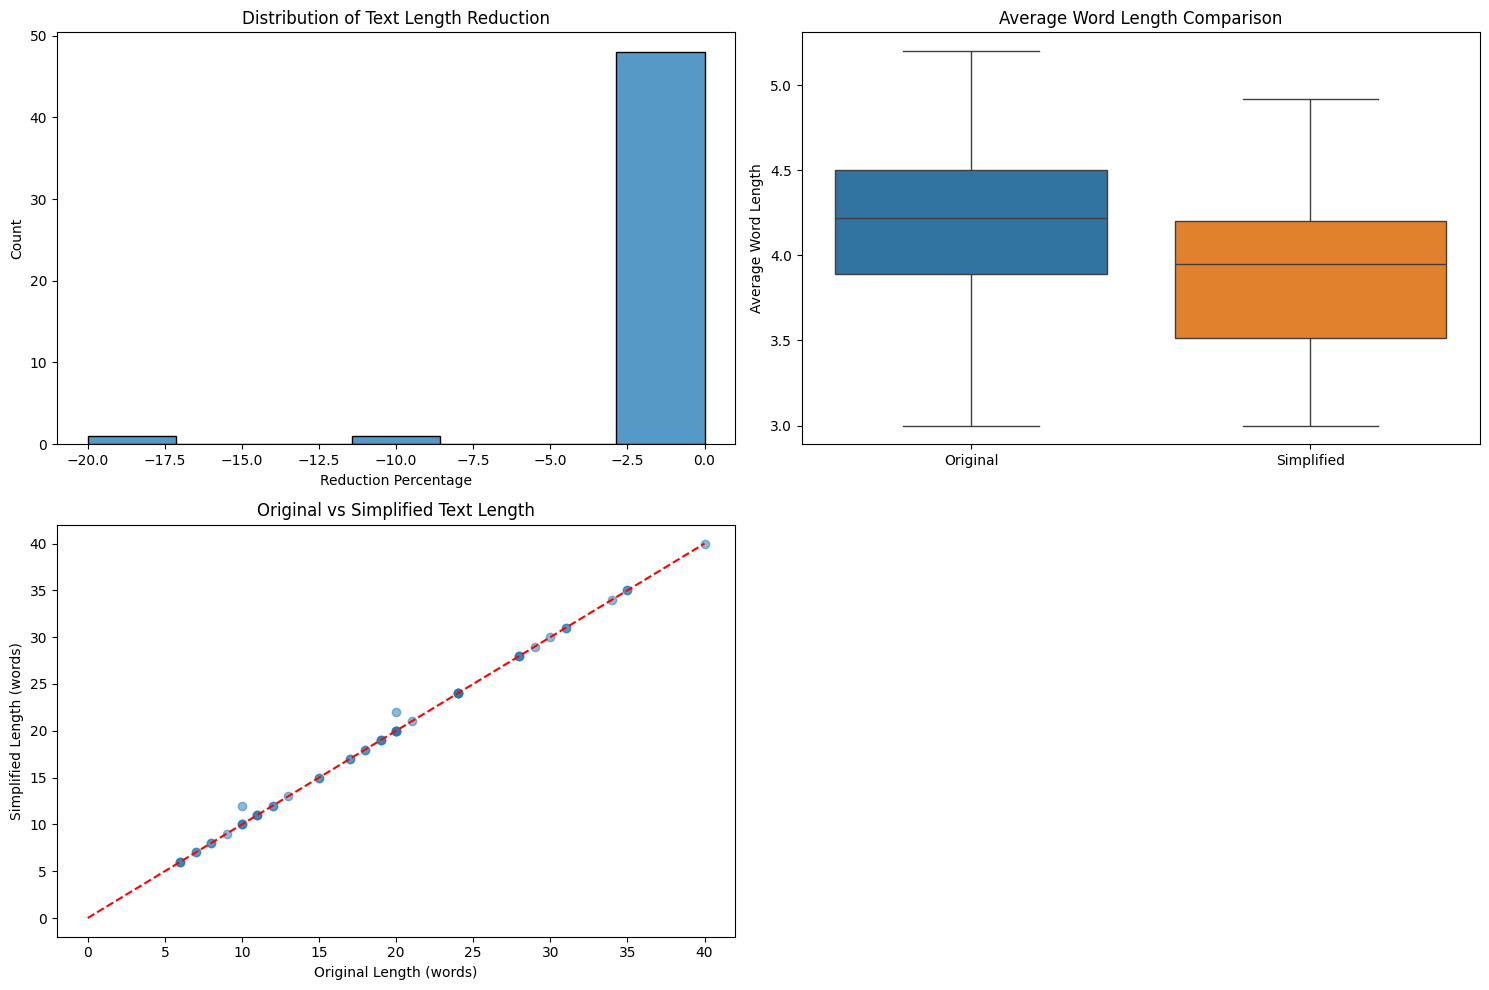


Results saved to 'simplification_results.csv'


In [6]:
def run_evaluation():
    # Initialize components
    print("Initializing components...")
    dataset = SimpleWikiDataset(num_examples=200)  # Process 200 examples
    train_data, val_data, test_data = dataset.load_data()
    simplifier = SimplificationPipeline()
    analyzer = SimplificationAnalyzer()

    print("\nProcessing test samples and collecting metrics...")
    detailed_results = []

    # Process a batch of test examples
    for idx, row in test_data.head(50).iterrows():
        original = row['sentences']
        simplified = simplifier.simplify_text(original)
        metrics = analyzer.analyze_simplification(original, simplified)

        result = {
            'original': original,
            'simplified': simplified,
            'length_reduction': metrics['length_reduction'],
            'orig_avg_word_len': metrics['orig_avg_word_len'],
            'simp_avg_word_len': metrics['simp_avg_word_len']
        }
        detailed_results.append(result)

        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1} examples...")

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(detailed_results)

    # Print summary statistics
    print("\nSummary Statistics:")
    print("Average length reduction: {:.2f}%".format(results_df['length_reduction'].mean()))
    print("Average word length reduction: {:.2f}".format(
        (results_df['orig_avg_word_len'] - results_df['simp_avg_word_len']).mean()
    ))

    # Display example simplifications
    print("\nExample Simplifications:")
    for i in range(3):
        print(f"\nExample {i+1}:")
        print("Original:", results_df['original'].iloc[i])
        print("Simplified:", results_df['simplified'].iloc[i])
        print("Length reduction:", f"{results_df['length_reduction'].iloc[i]:.2f}%")

    # Generate visualizations
    print("\nGenerating analysis plots...")
    analyzer.plot_results()

    return results_df

if __name__ == "__main__":
    results = run_evaluation()

    # Save results to CSV (optional)
    results.to_csv('simplification_results.csv', index=False)
    print("\nResults saved to 'simplification_results.csv'")

In [7]:
def interactive_demo(simplifier, analyzer):
    print("=== Text Simplification Demo ===")
    print("Enter 'quit' to exit\n")

    while True:
        # Get input from user
        text = input("\nEnter text to simplify: ")
        if text.lower() == 'quit':
            break

        # Process the text
        simplified = simplifier.simplify_text(text)
        metrics = analyzer.analyze_simplification(text, simplified)

        # Display results
        print("\nResults:")
        print("-" * 50)
        print("Original:", text)
        print("Simplified:", simplified)
        print("\nMetrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")
        print("-" * 50)

# Initialize components
simplifier = SimplificationPipeline()
analyzer = SimplificationAnalyzer()

# Run interactive demo
interactive_demo(simplifier, analyzer)

Initializing SimplificationPipeline...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Pipeline initialized successfully
=== Text Simplification Demo ===
Enter 'quit' to exit


Enter text to simplify: your work is more sophisticated than mine.

Results:
--------------------------------------------------
Original: your work is more sophisticated than mine.
Simplified: your work is more important than mine .

Metrics:
length_reduction: 0.0
orig_avg_word_len: 4.5
simp_avg_word_len: 4.0
--------------------------------------------------


KeyboardInterrupt: Interrupted by user

In [9]:
!pip install textstat

# Import required libraries
from textstat import textstat
import string
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import defaultdict
import pandas as pd
import nltk

class AdvancedEvaluator:
    def __init__(self):
        nltk.download('averaged_perceptron_tagger')
        self.metrics_cache = {}

    def calculate_metrics(self, original, simplified):
        """Calculate comprehensive set of evaluation metrics"""
        metrics = {
            # Readability Metrics
            'flesch_reading_ease': {
                'original': textstat.flesch_reading_ease(original),
                'simplified': textstat.flesch_reading_ease(simplified)
            },
            'dale_chall_score': {
                'original': textstat.dale_chall_readability_score(original),
                'simplified': textstat.dale_chall_readability_score(simplified)
            },

            # Lexical Complexity
            'avg_word_length': {
                'original': self._average_word_length(original),
                'simplified': self._average_word_length(simplified)
            },
            'lexical_diversity': {
                'original': self._lexical_diversity(original),
                'simplified': self._lexical_diversity(simplified)
            },

            # Syntactic Complexity
            'syntactic_complexity': {
                'original': self._calculate_syntactic_complexity(original),
                'simplified': self._calculate_syntactic_complexity(simplified)
            }
        }

        # Calculate improvements
        metrics['improvements'] = {
            key: {
                'change': metrics[key]['simplified'] - metrics[key]['original'],
                'percent_change': ((metrics[key]['simplified'] - metrics[key]['original'])
                                 / metrics[key]['original'] * 100)
                if metrics[key]['original'] != 0 else 0
            }
            for key in metrics.keys()
        }

        return metrics

    def _average_word_length(self, text):
        """Calculate average word length"""
        words = word_tokenize(text)
        if not words:
            return 0
        return sum(len(word) for word in words) / len(words)

    def _lexical_diversity(self, text):
        """Calculate lexical diversity (unique words / total words)"""
        words = word_tokenize(text.lower())
        if not words:
            return 0
        return len(set(words)) / len(words)

    def _calculate_syntactic_complexity(self, text):
        """Calculate syntactic complexity based on POS tags"""
        words = word_tokenize(text)
        pos_tags = pos_tag(words)

        # Count complex structures (e.g., subordinate clauses)
        complex_pos = ['IN', 'WDT', 'WP', 'WRB']  # Subordinating conjunctions and relative pronouns
        complexity_count = sum(1 for _, tag in pos_tags if tag in complex_pos)

        return complexity_count / len(words) if words else 0

def evaluate_simplification_batch(original_texts, simplified_texts, evaluator):
    """Evaluate a batch of simplifications"""
    results = []

    for orig, simp in zip(original_texts, simplified_texts):
        metrics = evaluator.calculate_metrics(orig, simp)
        results.append({
            'original': orig,
            'simplified': simp,
            'metrics': metrics
        })

    return results

def print_detailed_analysis(results):
    """Print detailed analysis of simplification results"""
    print("\nDetailed Simplification Analysis")
    print("=" * 50)

    # Calculate averages across all samples
    avg_metrics = defaultdict(lambda: defaultdict(float))
    count = len(results)

    for result in results:
        metrics = result['metrics']
        for metric_name, metric_values in metrics.items():
            if metric_name != 'improvements':
                avg_metrics[metric_name]['original'] += metric_values['original']
                avg_metrics[metric_name]['simplified'] += metric_values['simplified']

    # Print average improvements
    print("\nAverage Improvements:")
    for metric_name, values in avg_metrics.items():
        orig_avg = values['original'] / count
        simp_avg = values['simplified'] / count
        change = simp_avg - orig_avg
        percent_change = (change / orig_avg * 100) if orig_avg != 0 else 0

        print(f"\n{metric_name.replace('_', ' ').title()}:")
        print(f"  Original: {orig_avg:.2f}")
        print(f"  Simplified: {simp_avg:.2f}")
        print(f"  Change: {change:.2f} ({percent_change:.1f}%)")

# Example usage
def main():
    # Initialize components
    dataset = SimpleWikiDataset(num_examples=100)
    simplifier = SimplificationPipeline()
    evaluator = AdvancedEvaluator()

    # Load and process data
    train_data, val_data, test_data = dataset.load_data()

    # Process a batch of examples
    original_texts = test_data['sentences'].head(10).tolist()
    simplified_texts = [simplifier.simplify_text(text) for text in original_texts]

    # Evaluate results
    results = evaluate_simplification_batch(original_texts, simplified_texts, evaluator)

    # Print detailed analysis
    print_detailed_analysis(results)

    # Save detailed results to CSV
    results_df = pd.DataFrame({
        'original': original_texts,
        'simplified': simplified_texts,
        'metrics': [str(r['metrics']) for r in results]
    })
    results_df.to_csv('detailed_evaluation_results.csv', index=False)
    print("\nDetailed results saved to 'detailed_evaluation_results.csv'")

if __name__ == "__main__":
    main()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.9 MB/s eta 0:00:00
Initializing SimplificationPipeline...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Pipeline initialized successfully
Loading SimpleWiki dataset...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


  0%|          | 0/100 [00:00<?, ?it/s]

Dataset split complete:
Train set: 3310 sentences
Validation set: 413 sentences
Test set: 415 sentences

Detailed Simplification Analysis

Average Improvements:

Flesch Reading Ease:
  Original: 52.94
  Simplified: 69.75
  Change: 16.82 (31.8%)

Dale Chall Score:
  Original: 11.05
  Simplified: 10.42
  Change: -0.62 (-5.6%)

Avg Word Length:
  Original: 4.54
  Simplified: 4.02
  Change: -0.52 (-11.5%)

Lexical Diversity:
  Original: 0.92
  Simplified: 0.88
  Change: -0.05 (-5.1%)

Syntactic Complexity:
  Original: 0.11
  Simplified: 0.11
  Change: -0.00 (-0.4%)

Detailed results saved to 'detailed_evaluation_results.csv'


In [13]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics import precision_recall_fscore_support
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

class LexicalSimplifier:
    def __init__(self):
        print("Initializing BERT model...")
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.model = AutoModelForMaskedLM.from_pretrained('bert-base-uncased')
        self.max_length = 512

    def simplify_text(self, text):
        """Simplify text by processing it sentence by sentence"""
        sentences = sent_tokenize(text)
        simplified_sentences = []

        for sentence in sentences:
            simplified_sentence = self._simplify_sentence(sentence)
            simplified_sentences.append(simplified_sentence)

        return ' '.join(simplified_sentences)

    def _simplify_sentence(self, sentence):
        """Simplify a single sentence"""
        words = word_tokenize(sentence)
        simplified_words = []

        for word in words:
            if self._needs_simplification(word):
                simpler_word = self._find_simpler_word(word, sentence)
                simplified_words.append(simpler_word if simpler_word else word)
            else:
                simplified_words.append(word)

        return ' '.join(simplified_words)

    def _needs_simplification(self, word):
        """Determine if word needs simplification"""
        return (len(word) > 6 and
                word.isalpha() and
                not word.lower() in set(['between', 'through', 'another', 'against']))

    def _find_simpler_word(self, word, context):
        """Find a simpler replacement for the target word"""
        try:
            # Create masked version of the context
            masked_text = context.replace(word, self.tokenizer.mask_token, 1)

            # Tokenize input
            encoded = self.tokenizer(masked_text,
                                   truncation=True,
                                   max_length=self.max_length,
                                   return_tensors='pt')

            # Get mask token index
            mask_token_index = torch.where(encoded['input_ids'] == self.tokenizer.mask_token_id)[1]
            if len(mask_token_index) == 0:
                return None

            # Get model predictions
            with torch.no_grad():
                outputs = self.model(**encoded)

            # Get predictions for mask token
            mask_token_logits = outputs.logits[0, mask_token_index[0]]

            # Get top predictions
            top_k = 10  # Get more candidates to ensure we have valid ones after filtering
            top_tokens = torch.topk(mask_token_logits, top_k).indices

            # Convert token IDs to words and filter
            candidates = []
            for token_id in top_tokens:
                candidate = self.tokenizer.decode([token_id]).strip()
                if (candidate.isalpha() and
                    len(candidate) < len(word) and
                    candidate.lower() != word.lower()):
                    candidates.append(candidate)

            # Return the first valid candidate or None if no valid candidates
            return candidates[0] if candidates else None

        except Exception as e:
            print(f"Error processing word '{word}': {str(e)}")
            return None

def print_colored(text, color='green'):
    """Print text with color"""
    colors = {
        'green': '\033[92m',
        'red': '\033[91m',
        'blue': '\033[94m',
        'end': '\033[0m'
    }
    print(f"{colors[color]}{text}{colors['end']}")

def evaluate_simplification(original, simplified):
    """Calculate basic evaluation metrics"""
    original_words = set(word_tokenize(original.lower()))
    simplified_words = set(word_tokenize(simplified.lower()))

    changes = len(original_words - simplified_words)
    return {
        'changes': changes,
        'percent_changed': (changes / len(original_words)) * 100 if original_words else 0
    }

def main():
    # Initialize simplifier
    simplifier = LexicalSimplifier()

    # Load small test dataset
    print("Loading dataset...")
    dataset = load_dataset("wikipedia", "20220301.simple", split="train[:5]")

    # Process examples
    print("\nProcessing examples...")
    for i, example in enumerate(dataset):
        if example['text']:
            # Take first sentence for demonstration
            sentences = sent_tokenize(example['text'])
            if sentences:
                original = sentences[0]
                simplified = simplifier.simplify_text(original)
                metrics = evaluate_simplification(original, simplified)

                print(f"\nExample {i+1}:")
                print_colored("Original:", 'blue')
                print(original)
                print_colored("Simplified:", 'green')
                print(simplified)
                print_colored(f"Words changed: {metrics['changes']} ({metrics['percent_changed']:.1f}%)", 'red')

    # Test with specific example
    print("\nTesting with example text...")
    example = "The economic outlook remains uncertain due to various global factors."
    simplified = simplifier.simplify_text(example)

    print("\nSpecific Example:")
    print_colored("Original:", 'blue')
    print(example)
    print_colored("Simplified:", 'green')
    print(simplified)

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Initializing BERT model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading dataset...

Processing examples...

Example 1:
Original:
April is the fourth month of the year in the Julian and Gregorian calendars, and comes between March and May.
Simplified:
April is the fourth month of the year in the Julian and lunar calendar , and comes between March and May .
Words changed: 2 (11.1%)

Example 2:
Original:
August (Aug.) is the eighth month of the year in the Gregorian calendar, coming between July and September.
Simplified:
August ( Aug. ) is the eighth month of the year in the hindu system , coming between July and august .
Words changed: 3 (15.0%)

Example 3:
Original:
Art is a creative activity that expresses imaginative or technical skill.
Simplified:
Art is a visual process that requires artistic or artistic skill .
Words changed: 5 (41.7%)

Example 4:
Original:
A or a is the first letter of the English alphabet.
Simplified:
A or a is the first letter of the latin word .
Words changed: 2 (20.0%)

Example 5:
Original:
Air refers to the Earth's atmos